# Forensic Investigation Figures

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import importlib
import pandas as pd
import seaborn
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import Transformer as tnsf
import preprocess as ad

import sys
import copy
from matplotlib.colors import LogNorm
np.set_printoptions(threshold=sys.maxsize)

importlib.reload(ad)
importlib.reload(tnsf)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cuda"
print(device)

cuda


## Seaborn definitions for heatmap

In [2]:
def draw(data, x, y, ax, cbar, tight=True):
    seaborn.set(font_scale=1.3)
    #cmap = seaborn.cubehelix_palette(start=0.11, dark=0, rot=0.4, light=1, as_cmap=True)
    #cmap = seaborn.cubehelix_palette(start=1, dark=0.4, rot=0, light=1, as_cmap=True)
    cmap = seaborn.dark_palette("#ff0000", n_colors=10, reverse=True, as_cmap=True)
    mask = np.zeros_like(data, dtype=np.bool)
    
    if tight == True:
        # Get indices where ROWS are all zeros
        row_thicks = np.where(~np.all(data == 0, axis=1))
        ###print("Row Thicks",row_thicks)
        # Rows Delete
        data = data[~np.all(data == 0, axis=1)]
    
        # Get indices where COLUMNS are all zeros
        col_thicks = np.where(data.any(axis=0))[0]
        # Columns Delete
        data= np.delete(data,np.where(~data.any(axis=0))[0], axis=1)
        ###print("Col Thicks",col_thicks)
    
        col_thicks = list(col_thicks)
        row_thicks = list(row_thicks[0])
        
    else:
        col_thicks = range(0,data.shape[1])
        row_thicks = range(0,data.shape[0])
        numOfRows = data.shape[0] # length for Y
        numOfColumns = data.shape[1] #Length for X
        ###print("Row Thicks",row_thicks)
        ###print("Col Thicks",col_thicks)
    
    
    # Generate mask to change zero elements to white
    mask = (data == 0)
    print("New Heatmap Shape")
    print(data.shape)
    

#     seaborn.heatmap(data, xticklabels=28, square=True, yticklabels=28, vmin=0.0, vmax=1.0, cbar=cbar, cbar_ax = cbar_ax, ax=ax, cmap=cmap)
    with seaborn.axes_style("white"):
        seaborn.heatmap(data, xticklabels=col_thicks, square=True, yticklabels=row_thicks, vmin=0.00001, vmax=1.0, cbar=cbar, ax=ax, cmap=cmap, mask=mask) #norm=LogNorm()
        #seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.001, vmax=1.0, cbar=cbar, ax=ax, cmap=cmap, norm=LogNorm(), mask=mask) #norm=LogNorm()
    
    

## Reduce 2d array dimensionality

In [3]:
def matrix_reduce(data):
    # Get indices where ROWS are all zeros
    row_thicks = np.where(~np.all(data == 0, axis=1))
    # Rows Delete
    data = data[~np.all(data == 0, axis=1)]

    # Get indices where COLUMNS are all zeros
    col_thicks = np.where(data.any(axis=0))[0]
    # Columns Delete
    data= np.delete(data,np.where(~data.any(axis=0))[0], axis=1)

    col_thicks = list(col_thicks)
    row_thicks = list(row_thicks[0])

    print("New Heatmap Shape")
    print(data.shape)
    return data, row_thicks, col_thicks

## Attention scaler

In [4]:
# The following function scales the attention matrix
# This provides a better heatmap visualization
def scale_attention(attention_matrix):
    # Copy original attention
    attention_v2 = copy.deepcopy(attention_matrix)

    # Add 10 to eliminate negative number of log
    attention_v2[attention_v2!=0] += 10
    # Log Acale Attention Matrix
    attention_log = np.log10(attention_v2)
    # Substract 1 to bring smaller values closer to 0
    attention_log[attention_log!=0] -= 1
    # Set -Inf (Produced by Log Zero) to 0
    attention_log[np.isneginf(attention_log)]=0
    # Normalize Log Values
    attention_log_normalized =(attention_log-np.min(attention_log))/(np.max(attention_log)-np.min(attention_log))
    
#     if attention_log_normalized.ndim == 1:
        
#         #Returns a tuple of (nonzero_row_index, nonzero_col_index)
#         nonzero = np.nonzero(attention_log_normalized)
#         nonzero_elements = nonzero[0]

#         for element in nonzero_elements:
#             print("Attention[{}] = {}".format(element, attention_log_normalized[element]))
            
#     elif attention_log_normalized.ndim == 2:
                
#         #Returns a tuple of (nonzero_row_index, nonzero_col_index)
#         nonzero = np.nonzero(attention_log_normalized)
#         nonzero_row = nonzero[0]
#         nonzero_col = nonzero[1]

#         for row, col in zip(nonzero_row, nonzero_col):
#             print("A[{}, {}] = {}".format(row, col, attention_log_normalized[row, col]))        
        
#     else:
#         print("Undefined Dimension")
            
    return attention_log_normalized

In [ ]:
# Python Program to find GCD of Two Numbers

def findgcd(a, b):
    if(b == 0):
        return a;
    else:
        return findgcd(b, a % b)
    
# num1 = 168
# num2 = 48

# gcd = findgcd(num1, num2)
# print("\n GCD of {0} and {1} = {2}".format(num1, num2, gcd))

# Federated Normal and Abnormal

In [ ]:
with open('decoder_attentions/tn_Linux_Normal_attention.npy', 'rb') as f:
    attention_matrix_1 = np.load(f)
attention_matrix_1.shape

with open('decoder_attentions/tp_Linux_Abnormal_attention.npy', 'rb') as f:
    attention_matrix_2 = np.load(f)
attention_matrix_2.shape

In [ ]:
# Delete all zero elements in 2d attention array
attention_matrix_1_rd, rows_1, cols_1 = matrix_reduce(attention_matrix_1)
attention_matrix_2_rd, rows_2, cols_2 = matrix_reduce(attention_matrix_2)

# Sum attention over the input keys and scale it.
attention_matrix_1_sum = scale_attention(attention_matrix_1_rd.sum(axis=0))
attention_matrix_2_sum = scale_attention(attention_matrix_2_rd.sum(axis=0))

## Heatmap

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(attention_matrix_1), range(0,449), range(0,449), ax=axs[0], cbar=False)
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Label", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs[0].invert_yaxis()

draw(scale_attention(attention_matrix_2), range(0,449), range(0,449), ax=axs[1], cbar=True)
axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Label", fontsize=14)
axs[1].set_title("Federated Model\nAttention of Cyber Threats", fontsize=14)
axs[1].invert_yaxis()

axs[0].set_aspect('auto')
axs[1].set_aspect('auto')
axs[0].locator_params(nbins=16, axis='x')
axs[1].locator_params(nbins=16, axis='x')
axs[0].locator_params(nbins=16, axis='y')
axs[1].locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/federated_normal_and_cyber_threats_heatmap_v1.png')
plt.show()

## Heatmap - Single

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(attention_matrix_1), range(0,449), range(0,449), ax=axs, cbar=True)
#axs.set_xlabel("Log Keys from Input Sequences", fontsize=14)
#axs.set_ylabel("Label", fontsize=14)
#axs.set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs.invert_yaxis()

axs.set_aspect('auto')
axs.locator_params(nbins=16, axis='x')
axs.locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/single_federated_normal_and_cyber_threats_heatmap_v1.png')
plt.show()

## 3D Plot

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=(15,7))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_zlim(0, 1)
ax[1].set_zlim(0, 1)
# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(attention_matrix_1)
surf = ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(attention_matrix_2)
surf = ax[1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

ax[0].set(title="Federated Model\nAttention of Normal Operation")
ax[1].set(title="Federated Model\nAttention of Cyber Threats")

ax[0].set_xlabel("Log Keys from Input Sequences")
ax[0].set_ylabel("Label")

ax[1].set_xlabel("Log Keys from Input Sequences")
ax[1].set_ylabel("Label")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.savefig('figures/federated_normal_and_cyber_threats_3d_v1.png')
plt.show()

## Added Attention

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Log Key Frequency
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Attention", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs[0].bar(range(0,attention_matrix_1_sum.shape[0]), attention_matrix_1_sum, color = "blue")
axs[0].set_xticks(range(0,attention_matrix_1_sum.shape[0]))
axs[0].set_xlim([-0.5, attention_matrix_1_sum.shape[0]])
axs[0].set_xticklabels(cols_1, fontsize=9, rotation= 90)

axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Attention", fontsize=14)
axs[1].set_title("Federated Model\nAttention of Cyber Threats", fontsize=14)
axs[1].bar(range(0,attention_matrix_2_sum.shape[0]), attention_matrix_2_sum, color = "blue")
axs[1].set_xticks(range(0,attention_matrix_2_sum.shape[0]))
axs[1].set_xlim([-0.5, attention_matrix_2_sum.shape[0]])
axs[1].set_xticklabels(cols_2, fontsize=9, rotation= 90)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])

axs[0].locator_params(nbins=25, axis='x')
axs[1].locator_params(nbins=25, axis='x')

plt.setp(axs[0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1], xlabel="Log Keys from Input Sequences")
#plt.tight_layout()

plt.savefig('figures/federated_normal_and_cyber_threats_bar_v1.png')
plt.show()

# Local Client 1 vs Local Client 2 Normal

In [ ]:
with open('decoder_attentions/tn_Linux_Client1_Normal_attention.npy', 'rb') as f:
    attention_matrix_3 = np.load(f)
attention_matrix_3.shape

with open('decoder_attentions/tn_Linux_Client2_Normal_attention.npy', 'rb') as f:
    attention_matrix_4 = np.load(f)
attention_matrix_4.shape

In [ ]:
# Delete all zero elements in 2d attention array
attention_matrix_3_rd, rows_3, cols_3 = matrix_reduce(attention_matrix_3)
attention_matrix_4_rd, rows_4, cols_4 = matrix_reduce(attention_matrix_4)

# Sum attention over the input keys and scale it.
attention_matrix_3_sum = scale_attention(attention_matrix_3_rd.sum(axis=0))
attention_matrix_4_sum = scale_attention(attention_matrix_4_rd.sum(axis=0))

## Heatmap

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(attention_matrix_3), range(0,449), range(0,449), ax=axs[0], cbar=False)
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Label", fontsize=14)
axs[0].set_title("Client 1\nAttention of Normal Operation", fontsize=14)
axs[0].invert_yaxis()

draw(scale_attention(attention_matrix_4), range(0,449), range(0,449), ax=axs[1], cbar=True)
axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Label", fontsize=14)
axs[1].set_title("Client 2\nAttention of Normal Operation", fontsize=14)
axs[1].invert_yaxis()

axs[0].set_aspect('auto')
axs[1].set_aspect('auto')
axs[0].locator_params(nbins=16, axis='x')
axs[1].locator_params(nbins=16, axis='x')
axs[0].locator_params(nbins=16, axis='y')
axs[1].locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/local_2_clients_heatmap.png')
plt.show()

## Heatmap - Single

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(attention_matrix_4), range(0,449), range(0,449), ax=axs, cbar=True)
#axs.set_xlabel("Log Keys from Input Sequences", fontsize=14)
#axs.set_ylabel("Label", fontsize=14)
#axs.set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs.invert_yaxis()

axs.set_aspect('auto')
axs.locator_params(nbins=16, axis='x')
axs.locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/single_client2_heatmap.png')
plt.show()

## 3D Plot

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=(15,7))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_zlim(0, 1)
ax[1].set_zlim(0, 1)
# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(attention_matrix_3)
surf = ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(attention_matrix_4)
surf = ax[1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

ax[0].set(title="Client 1\nAttention of Normal Operation")
ax[1].set(title="Client 2\nAttention of Normal Operation")

ax[0].set_xlabel("Log Keys from Input Sequences")
ax[0].set_ylabel("Label")

ax[1].set_xlabel("Log Keys from Input Sequences")
ax[1].set_ylabel("Label")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.savefig('figures/local_2_clients_3d.png')
plt.show()

## Added Attention

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Log Key Frequency
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Attention", fontsize=14)
axs[0].set_title("Client 1\nAttention of Normal Operation", fontsize=14)
axs[0].bar(range(0,attention_matrix_3_sum.shape[0]), attention_matrix_3_sum, color = "blue")
axs[0].set_xticks(range(0,attention_matrix_3_sum.shape[0]))
axs[0].set_xlim([-0.5, attention_matrix_3_sum.shape[0]])
axs[0].set_xticklabels(cols_3, fontsize=9, rotation= 90)

axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Attention", fontsize=14)
axs[1].set_title("Client 2\nAttention of Normal Operation", fontsize=14)
axs[1].bar(range(0,attention_matrix_4_sum.shape[0]), attention_matrix_4_sum, color = "blue")
axs[1].set_xticks(range(0,attention_matrix_4_sum.shape[0]))
axs[1].set_xlim([-0.5, attention_matrix_4_sum.shape[0]])
axs[1].set_xticklabels(cols_4, fontsize=9, rotation= 90)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])

axs[0].locator_params(nbins=25, axis='x')
axs[1].locator_params(nbins=25, axis='x')

plt.setp(axs[0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1], xlabel="Log Keys from Input Sequences")
#plt.tight_layout()

plt.savefig('figures/local_2_clients_bar.png')
plt.show()

# Federated (Client 1 + Client 2) Normal vs Federated Abnormal

In [ ]:
# Generate federated attention by adding attention weights from clients 1 and 2
federated_normal = np.add(attention_matrix_3,attention_matrix_4)

# Delete all zero elements in 2d attention array
federated_normal_rd, rows_fed_norm, cols_fed_norm = matrix_reduce(federated_normal)

# Sum attention over the input keys and scale it.
federated_normal_sum = scale_attention(federated_normal_rd.sum(axis=0))

## Heatmap

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(federated_normal), range(0,449), range(0,449), ax=axs[0], cbar=False)
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Label", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs[0].invert_yaxis()

draw(scale_attention(attention_matrix_2), range(0,449), range(0,449), ax=axs[1], cbar=True)
axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Label", fontsize=14)
axs[1].set_title("Federated Model\nAttention of Cyber Threats", fontsize=14)
axs[1].invert_yaxis()

axs[0].set_aspect('auto')
axs[1].set_aspect('auto')
axs[0].locator_params(nbins=16, axis='x')
axs[1].locator_params(nbins=16, axis='x')
axs[0].locator_params(nbins=16, axis='y')
axs[1].locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/federated_normal_and_cyber_threats_heatmap_v2.png')
plt.show()

## 3D Plot

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=(15,7))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_zlim(0, 1)
ax[1].set_zlim(0, 1)
# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(federated_normal)
surf = ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(attention_matrix_2)
surf = ax[1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

ax[0].set(title="Federated Model\nAttention of Normal Operation")
ax[1].set(title="Federated Model\nAttention of Cyber Threats")

ax[0].set_xlabel("Log Keys from Input Sequences")
ax[0].set_ylabel("Label")

ax[1].set_xlabel("Log Keys from Input Sequences")
ax[1].set_ylabel("Label")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.savefig('figures/federated_normal_and_cyber_threats_3d_v2.png')
plt.show()

## Added Attention

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Log Key Frequency
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Attention", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs[0].bar(range(0,federated_normal_sum.shape[0]), federated_normal_sum, color = "blue")
axs[0].set_xticks(range(0,federated_normal_sum.shape[0]))
axs[0].set_xlim([-0.5, federated_normal_sum.shape[0]])
axs[0].set_xticklabels(cols_fed_norm, fontsize=9, rotation= 90)

axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Attention", fontsize=14)
axs[1].set_title("Federated Model\nAttention of Cyber Threats", fontsize=14)
axs[1].bar(range(0,attention_matrix_2_sum.shape[0]), attention_matrix_2_sum, color = "blue")
axs[1].set_xticks(range(0,attention_matrix_2_sum.shape[0]))
axs[1].set_xlim([-0.5, attention_matrix_2_sum.shape[0]])
axs[1].set_xticklabels(cols_2, fontsize=9, rotation= 90)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])

axs[0].locator_params(nbins=25, axis='x')
axs[1].locator_params(nbins=25, axis='x')

plt.setp(axs[0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1], xlabel="Log Keys from Input Sequences")
#plt.tight_layout()

plt.savefig('figures/federated_normal_and_cyber_threats_bar_v2.png')
plt.show()

# Abnormal DDoS

In [5]:
with open('decoder_attentions/tp_DDoS-001_attention.npy', 'rb') as f:
    BT_DDoS_001 = np.load(f)
print(BT_DDoS_001.shape)

with open('decoder_attentions/tp_NTP-DDoS-Amplification_attention.npy', 'rb') as f:
    NTP_DDoS = np.load(f)
print(NTP_DDoS.shape)

with open('decoder_attentions/tp_SYN-Flood_attention.npy', 'rb') as f:
    SYN_Flood = np.load(f)
print(SYN_Flood.shape)

(449, 449)
(449, 449)
(449, 449)


In [6]:
# Generate federated attention by adding attention weights from DDoS Attack Samples
federated_ddos = np.add(BT_DDoS_001,NTP_DDoS,SYN_Flood)

# Delete all zero elements in 2d attention array
federated_ddos_rd, rows_fed_ddos, cols_fed_ddos = matrix_reduce(federated_ddos)
BT_DDoS_001_rd, rows_bt_ddos, cols_bt_ddos = matrix_reduce(BT_DDoS_001)
NTP_DDoS_rd, rows_ntp_ddos, cols_ntp_ddos = matrix_reduce(NTP_DDoS)
SYN_Flood_rd, rows_syn_flood, cols_syn_flood = matrix_reduce(SYN_Flood)

# Sum attention over the input keys and scale it.
federated_ddos_sum = scale_attention(federated_ddos_rd.sum(axis=0))
BT_DDoS_001_sum = scale_attention(BT_DDoS_001_rd.sum(axis=0))
NTP_DDoS_sum = scale_attention(NTP_DDoS_rd.sum(axis=0))
SYN_Flood_sum = scale_attention(SYN_Flood_rd.sum(axis=0))

New Heatmap Shape
(42, 38)
New Heatmap Shape
(11, 10)
New Heatmap Shape
(37, 29)
New Heatmap Shape
(42, 38)


## Heatmap

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20, 5))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(federated_ddos), range(0,449), range(0,449), ax=axs[0], cbar=False)
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Label", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Normal Operation", fontsize=14)
axs[0].invert_yaxis()

draw(scale_attention(BT_DDoS_001), range(0,449), range(0,449), ax=axs[1], cbar=True)
axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Label", fontsize=14)
axs[1].set_title("Federated Model\nAttention of BT DDoS Attack", fontsize=14)
axs[1].invert_yaxis()

draw(scale_attention(NTP_DDoS), range(0,449), range(0,449), ax=axs[2], cbar=True)
axs[2].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[2].set_ylabel("Label", fontsize=14)
axs[2].set_title("Federated Model\nAttention of NTP DDoS Attack", fontsize=14)
axs[2].invert_yaxis()

draw(scale_attention(SYN_Flood), range(0,449), range(0,449), ax=axs[3], cbar=True)
axs[3].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[3].set_ylabel("Label", fontsize=14)
axs[3].set_title("Federated Model\nAttention of SYN Flood Attack", fontsize=14)
axs[3].invert_yaxis()

axs[0].set_aspect('auto')
axs[1].set_aspect('auto')
axs[2].set_aspect('auto')
axs[3].set_aspect('auto')
axs[0].locator_params(nbins=16, axis='x')
axs[1].locator_params(nbins=16, axis='x')
axs[2].locator_params(nbins=16, axis='x')
axs[3].locator_params(nbins=16, axis='x')
axs[0].locator_params(nbins=16, axis='y')
axs[1].locator_params(nbins=16, axis='y')
axs[2].locator_params(nbins=16, axis='y')
axs[3].locator_params(nbins=16, axis='y')
#plt.tight_layout()

plt.savefig('figures/federated_ddos_heatmap.png')
plt.show()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


New Heatmap Shape
(37, 29)
New Heatmap Shape
(42, 38)
New Heatmap Shape
(11, 10)
New Heatmap Shape
(42, 38)


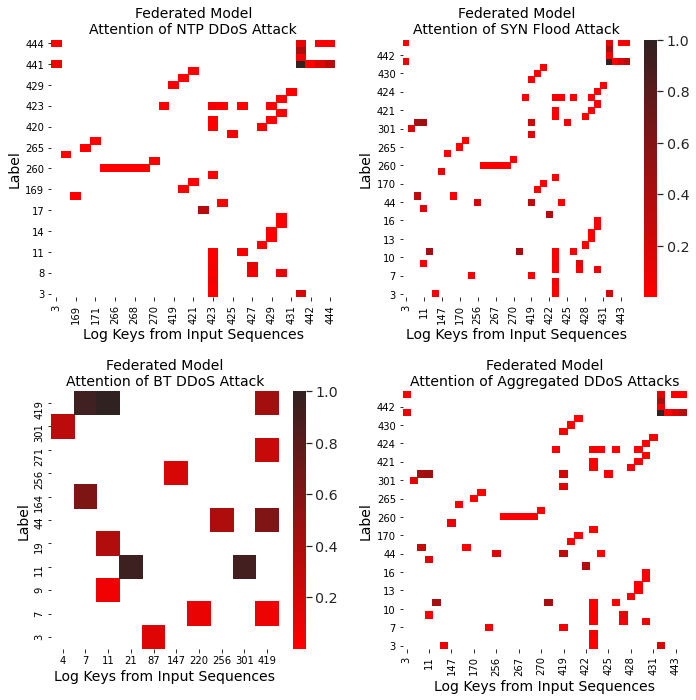

In [7]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(NTP_DDoS), range(0,449), range(0,449), ax=axs[0,0], cbar=False)
axs[0,0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0,0].set_ylabel("Label", fontsize=14)
axs[0,0].set_title("Federated Model\nAttention of NTP DDoS Attack", fontsize=14)
axs[0,0].invert_yaxis()

draw(scale_attention(SYN_Flood), range(0,449), range(0,449), ax=axs[0,1], cbar=True)
axs[0,1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0,1].set_ylabel("Label", fontsize=14)
axs[0,1].set_title("Federated Model\nAttention of SYN Flood Attack", fontsize=14)
axs[0,1].invert_yaxis()

draw(scale_attention(BT_DDoS_001), range(0,449), range(0,449), ax=axs[1,0], cbar=True)
axs[1,0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1,0].set_ylabel("Label", fontsize=14)
axs[1,0].set_title("Federated Model\nAttention of BT DDoS Attack", fontsize=14)
axs[1,0].invert_yaxis()

draw(scale_attention(federated_ddos), range(0,449), range(0,449), ax=axs[1,1], cbar=False)
axs[1,1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1,1].set_ylabel("Label", fontsize=14)
axs[1,1].set_title("Federated Model\nAttention of Aggregated DDoS Attacks", fontsize=14)
axs[1,1].invert_yaxis()

axs[0,0].set_aspect('auto')
axs[0,1].set_aspect('auto')
axs[1,0].set_aspect('auto')
axs[1,1].set_aspect('auto')
axs[0,0].locator_params(nbins=16, axis='x')
axs[0,1].locator_params(nbins=16, axis='x')
axs[1,0].locator_params(nbins=16, axis='x')
axs[1,1].locator_params(nbins=16, axis='x')
axs[0,0].locator_params(nbins=16, axis='y')
axs[0,1].locator_params(nbins=16, axis='y')
axs[1,0].locator_params(nbins=16, axis='y')
axs[1,1].locator_params(nbins=16, axis='y')
plt.tight_layout()

plt.savefig('figures/federated_ddos_heatmap_v2.png')
plt.show()

## 3D Plot

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=1, ncols=4, subplot_kw=dict(projection='3d'),figsize=(20,5))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()
ax[0].set_zlim(0, 1)
ax[1].set_zlim(0, 1)
ax[2].set_zlim(0, 1)
ax[3].set_zlim(0, 1)
# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(federated_ddos)
surf = ax[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(BT_DDoS_001)
surf = ax[1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(NTP_DDoS)
surf = ax[2].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(SYN_Flood)
surf = ax[3].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

ax[0].set(title="Federated Model\nAttention of Aggregated DDoS Attacks")
ax[1].set(title="Federated Model\nAttention of BT DDoS Attack")
ax[2].set(title="Federated Model\nAttention of NTP DDoS Attack")
ax[3].set(title="Federated Model\nAttention of SYN Flood Attack")

ax[0].set_xlabel("Log Keys from Input Sequences")
ax[0].set_ylabel("Label")

ax[1].set_xlabel("Log Keys from Input Sequences")
ax[1].set_ylabel("Label")

ax[2].set_xlabel("Log Keys from Input Sequences")
ax[2].set_ylabel("Label")

ax[3].set_xlabel("Log Keys from Input Sequences")
ax[3].set_ylabel("Label")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.savefig('figures/federated_ddos_3d_v1.png')
plt.show()

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='3d'),figsize=(15,15))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)
ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[0,0].set_zlim(0, 1)
ax[0,1].set_zlim(0, 1)
ax[1,0].set_zlim(0, 1)
ax[1,1].set_zlim(0, 1)
# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(federated_ddos)
surf = ax[0,0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(BT_DDoS_001)
surf = ax[0,1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(NTP_DDoS)
surf = ax[1,0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

Z = scale_attention(SYN_Flood)
surf = ax[1,1].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

ax[0,0].set(title="Federated Model\nAttention of Aggregated DDoS Attacks")
ax[0,1].set(title="Federated Model\nAttention of BT DDoS Attack")
ax[1,0].set(title="Federated Model\nAttention of NTP DDoS Attack")
ax[1,1].set(title="Federated Model\nAttention of SYN Flood Attack")

ax[0,0].set_xlabel("Log Keys from Input Sequences")
ax[0,0].set_ylabel("Label")

ax[0,1].set_xlabel("Log Keys from Input Sequences")
ax[0,1].set_ylabel("Label")

ax[1,0].set_xlabel("Log Keys from Input Sequences")
ax[1,0].set_ylabel("Label")

ax[1,1].set_xlabel("Log Keys from Input Sequences")
ax[1,1].set_ylabel("Label")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.savefig('figures/federated_ddos_3d_v2.png')
plt.show()

## Added Attention

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20, 5))

# Log Key Frequency
axs[0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0].set_ylabel("Attention", fontsize=14)
axs[0].set_title("Federated Model\nAttention of Aggregated DDoS Attacks", fontsize=14)
axs[0].bar(range(0,federated_ddos_sum.shape[0]), federated_ddos_sum, color = "blue")
axs[0].set_xticks(range(0,federated_ddos_sum.shape[0]))
axs[0].set_xlim([-0.5, federated_ddos_sum.shape[0]])
axs[0].set_xticklabels(cols_fed_ddos, fontsize=8, rotation= 90)

axs[1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1].set_ylabel("Attention", fontsize=14)
axs[1].set_title("Federated Model\nAttention of BT DDoS Attack", fontsize=14)
axs[1].bar(range(0,BT_DDoS_001_sum.shape[0]), BT_DDoS_001_sum, color = "blue")
axs[1].set_xticks(range(0,BT_DDoS_001_sum.shape[0]))
axs[1].set_xlim([-0.5, BT_DDoS_001_sum.shape[0]])
axs[1].set_xticklabels(cols_bt_ddos, fontsize=8, rotation= 90)

axs[2].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[2].set_ylabel("Attention", fontsize=14)
axs[2].set_title("Federated Model\nAttention of NTP DDoS Attack", fontsize=14)
axs[2].bar(range(0,NTP_DDoS_sum.shape[0]), NTP_DDoS_sum, color = "blue")
axs[2].set_xticks(range(0,NTP_DDoS_sum.shape[0]))
axs[2].set_xlim([-0.5, NTP_DDoS_sum.shape[0]])
axs[2].set_xticklabels(cols_ntp_ddos, fontsize=8, rotation= 90)

axs[3].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[3].set_ylabel("Attention", fontsize=14)
axs[3].set_title("Federated Model\nAttention of SYN Flood Attack", fontsize=14)
axs[3].bar(range(0,SYN_Flood_sum.shape[0]), SYN_Flood_sum, color = "blue")
axs[3].set_xticks(range(0,SYN_Flood_sum.shape[0]))
axs[3].set_xlim([-0.5, SYN_Flood_sum.shape[0]])
axs[3].set_xticklabels(cols_syn_flood, fontsize=8, rotation= 90)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])
axs[2].set_ylim([0, 1])
axs[3].set_ylim([0, 1])

plt.setp(axs[0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1], xlabel="Log Keys from Input Sequences")
plt.setp(axs[2], xlabel="Log Keys from Input Sequences")
plt.setp(axs[3], xlabel="Log Keys from Input Sequences")
plt.tight_layout()

plt.savefig('figures/federated_ddos_bar_v1.png')
plt.show()

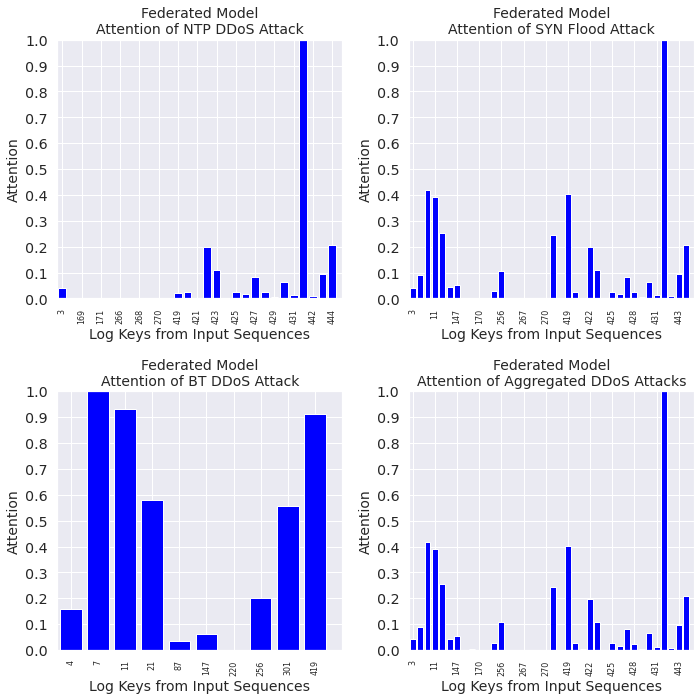

In [8]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))

# Aggregated Attention by Log Key
axs[0,0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0,0].set_ylabel("Attention", fontsize=14)
axs[0,0].set_title("Federated Model\nAttention of NTP DDoS Attack", fontsize=14)
axs[0,0].bar(range(0,NTP_DDoS_sum.shape[0]), NTP_DDoS_sum, color = "blue")
axs[0,0].set_xticks(range(0,NTP_DDoS_sum.shape[0]))
axs[0,0].set_xlim([-0.5, NTP_DDoS_sum.shape[0]])
axs[0,0].set_xticklabels(cols_ntp_ddos, fontsize=8, rotation= 90)

axs[0,1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[0,1].set_ylabel("Attention", fontsize=14)
axs[0,1].set_title("Federated Model\nAttention of SYN Flood Attack", fontsize=14)
axs[0,1].bar(range(0,SYN_Flood_sum.shape[0]), SYN_Flood_sum, color = "blue")
axs[0,1].set_xticks(range(0,SYN_Flood_sum.shape[0]))
axs[0,1].set_xlim([-0.5, SYN_Flood_sum.shape[0]])
axs[0,1].set_xticklabels(cols_syn_flood, fontsize=8, rotation= 90)

axs[1,0].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1,0].set_ylabel("Attention", fontsize=14)
axs[1,0].set_title("Federated Model\nAttention of BT DDoS Attack", fontsize=14)
axs[1,0].bar(range(0,BT_DDoS_001_sum.shape[0]), BT_DDoS_001_sum, color = "blue")
axs[1,0].set_xticks(range(0,BT_DDoS_001_sum.shape[0]))
axs[1,0].set_xlim([-0.5, BT_DDoS_001_sum.shape[0]])
axs[1,0].set_xticklabels(cols_bt_ddos, fontsize=8, rotation= 90)

axs[1,1].set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs[1,1].set_ylabel("Attention", fontsize=14)
axs[1,1].set_title("Federated Model\nAttention of Aggregated DDoS Attacks", fontsize=14)
axs[1,1].bar(range(0,federated_ddos_sum.shape[0]), federated_ddos_sum, color = "blue")
axs[1,1].set_xticks(range(0,federated_ddos_sum.shape[0]))
axs[1,1].set_xlim([-0.5, federated_ddos_sum.shape[0]])
axs[1,1].set_xticklabels(cols_fed_ddos, fontsize=8, rotation= 90)

axs[0,0].set_ylim([0, 1])
axs[0,1].set_ylim([0, 1])
axs[1,0].set_ylim([0, 1])
axs[1,1].set_ylim([0, 1])

plt.setp(axs[0,0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[0,1], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1,0], xlabel="Log Keys from Input Sequences")
plt.setp(axs[1,1], xlabel="Log Keys from Input Sequences")
plt.tight_layout()

axs[0,0].set_aspect('auto')
axs[0,1].set_aspect('auto')
axs[1,0].set_aspect('auto')
axs[1,1].set_aspect('auto')
axs[0,0].locator_params(nbins=16, axis='x')
axs[0,1].locator_params(nbins=16, axis='x')
axs[1,0].locator_params(nbins=16, axis='x')
axs[1,1].locator_params(nbins=16, axis='x')
axs[0,0].locator_params(nbins=16, axis='y')
axs[0,1].locator_params(nbins=16, axis='y')
axs[1,0].locator_params(nbins=16, axis='y')
axs[1,1].locator_params(nbins=16, axis='y')

plt.savefig('figures/federated_ddos_bar_v2.png')
plt.show()

# Run for a Specific Example

## Individual Example

In [ ]:
with open('decoder_attentions/tp_Malaria_attention.npy', 'rb') as f:
    attention_matrix_x = np.load(f)
attention_matrix_x.shape

In [ ]:
# Sum attention over the input keys and scale it.
attention_matrix_x_rd, rows, cols = matrix_reduce(attention_matrix_x)
attention_matrix_x_sum = scale_attention(attention_matrix_x_rd.sum(axis=0))
print(attention_matrix_x_sum)
print(len(attention_matrix_x_sum))

## Heatmap

In [ ]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(1,1, figsize=(10, 10))

# Attention Heatmaps

# Aggregated Attention by Log Key (Input Sequences)
draw(scale_attention(attention_matrix_x), range(0,449), range(0,449), ax=axs, cbar=True)
axs.set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs.set_ylabel("Label", fontsize=14)
axs.set_title("Federated Model\nAttention of Malaria", fontsize=14)
axs.invert_yaxis()

x_labels = [item.get_text() for item in axs.get_xticklabels()]
y_labels = [item.get_text() for item in axs.get_yticklabels()]

axs.locator_params(nbins=18, axis='x')
axs.locator_params(nbins=18, axis='y')

stepsize=1
start, end = axs.get_xlim()
axs.set_xticks(np.arange(start, end, stepsize))
axs.set_xticks(np.arange(start+0.5, end+0.5, stepsize), minor=True)
axs.set_xticklabels(x_labels, minor=True, rotation= 90)
start, end = axs.get_ylim()
axs.set_yticks(np.arange(start, end, stepsize))
axs.set_yticks(np.arange(start+0.5, end+0.5, stepsize), minor=True)
axs.set_yticklabels(y_labels, minor=True)
axs.grid(color = 'black', linestyle = '--', linewidth = 0.5, which="major", alpha=0.6)

axs.set_axisbelow(True)

axs.set_aspect('auto')
plt.tight_layout()

plt.savefig('figures/abnormal_sample_heatmap.png')
plt.show()

## 3D Plot

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'),figsize=plt.figaspect(3/6))
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection='3d'),figsize=(10,10))

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = range(0,449)
Y = range(0,449)
X, Y = np.meshgrid(X, Y)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_zlim(0, 1)

attention_matrix_x_rd, rows, cols = matrix_reduce(attention_matrix_x)
print("Rows:",rows)
print("Columns:",cols)

# Aggregated Attention by Log Key (Input Sequences)
Z = scale_attention(attention_matrix_x_rd)
X = range(0,len(cols))
Y = range(0,len(rows))
print("Rows:",Y)
print("Columns:",X)

ax.set_xticks(X)
ax.set_yticks(Y)

X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,vmin=0)

# ax.locator_params(nbins=16, axis='x')
# ax.locator_params(nbins=12, axis='y')
ax.set(title="Federated Model\nAttention of Malaria")
ax.set_xlabel("\nLog Keys from Input Sequences")
ax.set_ylabel("\nLabel")
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel("Attention", fontsize=10, rotation = 90)#270
ax.set_xticklabels(cols, fontsize=7, rotation = -30)#50
ax.set_yticklabels(rows, fontsize=7, rotation = 40)#235
ax.view_init(30,220)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.savefig('figures/abnormal_sample_3d.png')
plt.show()

## Added Attention

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(20, 10))

# Log Key Frequency
axs.set_xlabel("Log Keys from Input Sequences", fontsize=14)
axs.set_ylabel("Attention", fontsize=14)
axs.set_title("Federated Model\nAttention of Malaria", fontsize=14)
axs.bar(np.arange(attention_matrix_x_sum.shape[0]), attention_matrix_x_sum, color = "blue")
axs.set_xticks(range(0,attention_matrix_x_sum.shape[0]))
axs.set_xlim([-0.5, attention_matrix_x_sum.shape[0]])
axs.set_xticklabels(cols, rotation= 90)
axs.set_ylim([0, 1])
#plt.tight_layout()

plt.savefig('figures/abnormal_sample_bar.png')
plt.show()